# Asnwers to questions:
- **What are the most common medications for each disease in the base file?**
See results in the table rendered after medicine_pop() function application. The top 3 medicines for 10 diseases include only 9 medicines where the top medicines are less than 5.7% of all diagnosed users. The same medicine is prescribed on many diseases.  
- **What medications are most indicative of each disease?**
Please see the table below in one of the paragraphs. For example, 87% of all total Metformin prescriptions and 37% of total Lisinopril prescriptions up to latest date have users with diabetes. In other words some medicinces were prescribed more than 1 time and they were double counted in the below table, i.e. we didn't normalize the table for each medicine to be considered only once.
- **Choose ONE of the diseases and build a model to infer whether that disease is present from the medications.**
I build two models (logistic regression and catboost) to identify whether diabetes is present from the medicines. 
- **Demonstrate that the end user should be confident in the result.**
The ROC AUC scores of the two models were not high, especially for tests, a bit more than 80%.According to the precision / recall curve for logistic regression, at recall level of 0.8 (i.e. we predict correctly 80% of predictions), we only identify around 50% of all people with diabetes. It means that if we are interested in identifying as many people with diabetes as possible, then we need to create a better model, with more carefully selected features.




In [2]:
import pandas as pd
import numpy as np
import math
import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import plotly.graph_objects as go 
import scipy.stats as stats
from scipy import stats

from scipy.stats import mannwhitneyu, norm, t, nct, rankdata, ttest_ind

In [3]:
df_base=pd.read_csv('meps_base_data.csv')
print (df_base.head())
print (df_base.describe())

   Unnamed: 0        id  panel  pooledWeight  age     sex      race  \
0           1  10007101     15   3603.881236   28    Male     White   
1           2  10007102     15   2544.550424   25  Female     White   
2           3  10007103     15   4050.397468    4    Male     White   
3           4  10007104     15   3064.059720    3  Female     White   
4           5  10008101     15   3635.552466   51    Male  Multiple   

                   married highBPDiagnosed diabetesDiagnosed  chdDiagnosed  \
0                  MARRIED             Yes                No            No   
1                  MARRIED              No                No            No   
2  UNDER 16 - INAPPLICABLE    Inapplicable      Inapplicable  Inapplicable   
3  UNDER 16 - INAPPLICABLE    Inapplicable      Inapplicable  Inapplicable   
4                  MARRIED              No                No            No   

    miDiagnosed anginaDiagnosed strokeDiagnosed emphysemaDiagnosed  \
0            No              No   

In [4]:
#lets check if we have repeating id
df_base.groupby('id').count()['panel'].sort_values(ascending=False)

id
10007101    1
76147103    1
75975103    1
75976101    1
75978101    1
           ..
43431101    1
43431102    1
43431103    1
43431104    1
89688102    1
Name: panel, Length: 61489, dtype: int64

In [5]:
#lets check the null data
df_base.isnull().mean()

Unnamed: 0               0.0
id                       0.0
panel                    0.0
pooledWeight             0.0
age                      0.0
sex                      0.0
race                     0.0
married                  0.0
highBPDiagnosed          0.0
diabetesDiagnosed        0.0
chdDiagnosed             0.0
miDiagnosed              0.0
anginaDiagnosed          0.0
strokeDiagnosed          0.0
emphysemaDiagnosed       0.0
asthmaDiagnosed          0.0
otherHDDiagnosed         0.0
heartFailureDiagnosed    0.0
dtype: float64

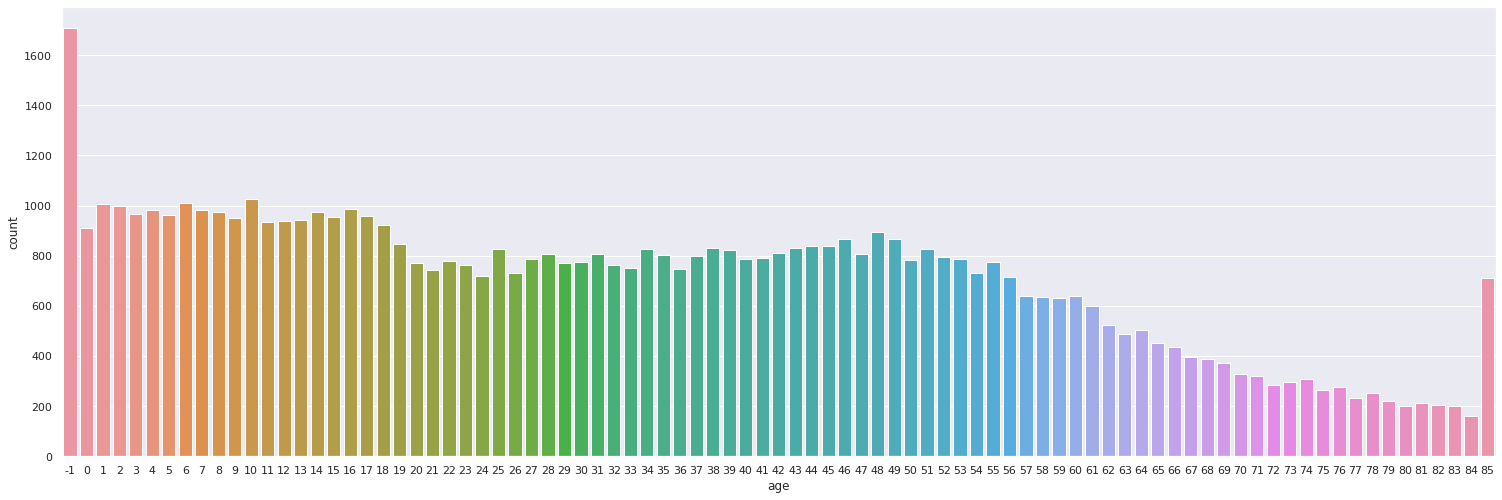

In [6]:
#Lets check the prevalence of negative age data
sns.set(rc={'figure.figsize':(25.7,8.27)})
sns.countplot(df_base['age'])


In [7]:
#lets glance at negative age patients
df_base[df_base['age']==-1].head(20)

,Unnamed: 0,id,panel,pooledWeight,age,sex,race,married,highBPDiagnosed,diabetesDiagnosed,chdDiagnosed,miDiagnosed,anginaDiagnosed,strokeDiagnosed,emphysemaDiagnosed,asthmaDiagnosed,otherHDDiagnosed,heartFailureDiagnosed
18,19,10016106,15,3350.219230,-1,Male,Multiple,INAPPLICABLE,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,No,Inapplicable,No
104,105,10073104,15,2324.790489,-1,Female,Black,INAPPLICABLE,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,No,Inapplicable,No
105,106,10073105,15,1837.365888,-1,Female,Black,INAPPLICABLE,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,No
179,180,10120114,15,2889.047827,-1,Male,White,INAPPLICABLE,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,No
236,237,10140201,15,2764.797184,-1,Male,White,INAPPLICABLE,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,No
270,271,10157103,15,5749.295298,-1,Female,White,INAPPLICABLE,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,No,Inapplicable,No
286,287,10171104,15,1943.141533,-1,Male,White,INAPPLICABLE,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,No,Inapplicable,No
302,303,10184104,15,1928.625577,-1,Male,White,INAPPLICABLE,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,No
367,368,10206105,15,4961.044625,-1,Female,Asian,INAPPLICABLE,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,No
516,517,10305104,15,2433.804144,-1,Female,Black,INAPPLICABLE,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,No


Lets calculate the values of diagnosed diseases for each diagnosis. 
The vast majority in all diseases except heart failure is Inapplicable. It looks like it applied in situations where the patient was not checked for this disease.

In [8]:

dis = ['highBPDiagnosed', 'diabetesDiagnosed', 'chdDiagnosed',
       'miDiagnosed', 'anginaDiagnosed', 'strokeDiagnosed',
       'emphysemaDiagnosed', 'asthmaDiagnosed', 'otherHDDiagnosed',
       'heartFailureDiagnosed']
for d in dis:
  print (d)
  print (df_base[d][df_base['age']==-1].value_counts(dropna = False))

highBPDiagnosed
Inapplicable    1598
No                84
Yes               25
DK                 1
Name: highBPDiagnosed, dtype: int64
diabetesDiagnosed
Inapplicable    1598
No               102
Yes                8
Name: diabetesDiagnosed, dtype: int64
chdDiagnosed
Inapplicable    1598
No               107
Yes                3
Name: chdDiagnosed, dtype: int64
miDiagnosed
Inapplicable    1598
No               108
Yes                2
Name: miDiagnosed, dtype: int64
anginaDiagnosed
Inapplicable    1598
No               110
Name: anginaDiagnosed, dtype: int64
strokeDiagnosed
Inapplicable    1598
No               107
Yes                3
Name: strokeDiagnosed, dtype: int64
emphysemaDiagnosed
Inapplicable    1598
No               109
Yes                1
Name: emphysemaDiagnosed, dtype: int64
asthmaDiagnosed
Inapplicable    920
No              765
Yes              23
Name: asthmaDiagnosed, dtype: int64
otherHDDiagnosed
Inapplicable    1598
No               102
Yes                8
Name: o

In [9]:
df_meds=pd.read_csv('meps_meds.csv')
print (df_meds.head())
print (df_meds.describe())

   Unnamed: 0        id  rxStartMonth  rxStartYear  \
0           1  10007104             3         2011   
1           2  10007104             3         2011   
2           3  10008102             3         2011   
3           4  10008102             3         2011   
4           5  10008102             9         2011   

                           rxName        rxNDC  rxQuantity rxForm  
0                     AMOXICILLIN    143988775        75.0   SUSR  
1              OTIC EDGE SOLUTION  68032032814        14.0    SOL  
2  NASAL DECONGESTANT 0.05% SPRAY  63981056903        15.0    SPR  
3  NASAL DECONGESTANT 0.05% SPRAY  63981056903        15.0    SPR  
4                    DIPHENHYDRAM    603333921        30.0    CAP  
         Unnamed: 0            id   rxStartMonth    rxStartYear         rxNDC  \
count  4.293040e+05  4.293040e+05  429304.000000  429304.000000  4.293040e+05   
mean   4.443042e+05  2.590337e+07       0.867765    1642.630891  2.300384e+10   
std    5.767333e+05  1.4

# Lets drop duplicates and drop the columns

In [10]:
df_meds.drop(columns='Unnamed: 0',inplace=True)
df_meds.drop_duplicates(inplace=True)
df_meds.describe()



,id,rxStartMonth,rxStartYear,rxNDC,rxQuantity
count,1.303600e+05,130360.000000,130360.000000,1.303600e+05,130359.000000
mean,2.628636e+07,1.767789,1690.796717,2.391517e+10,70.880990
std,1.504778e+07,5.102994,732.783205,2.868372e+10,755.132182
min,1.000710e+07,-9.000000,-14.000000,-9.000000e+00,-9.000000
25%,1.359610e+07,-1.000000,2000.000000,1.730696e+08,30.000000
50%,1.724110e+07,-1.000000,2009.000000,7.036801e+08,30.000000
75%,4.335110e+07,6.000000,2010.000000,5.486810e+10,90.000000
max,4.967110e+07,12.000000,2011.000000,9.920705e+10,120000.000000


In [11]:
#some of ids have many data points
df_meds.groupby('id').count()['rxForm'].sort_values(ascending=False)

id
12220101    87
17082101    83
10624101    80
16961101    73
17608101    70
            ..
44975102     1
15473103     1
15473104     1
15473105     1
18407103     1
Name: rxForm, Length: 18535, dtype: int64

Let see the values for one of the top users

In [12]:
df_meds[df_meds['id']==44246101].head(10)

,id,rxStartMonth,rxStartYear,rxName,rxNDC,rxQuantity,rxForm
336128,44246101,1,2010,PREDNISOLONE,61314063705,5.0,SUSP
336129,44246101,-1,1995,WARFARIN,68382005310,90.0,TABS
336130,44246101,-1,-8,POT CHLORIDE,781152601,60.0,TBCR
336131,44246101,-1,-8,FUROSEMIDE,781144605,30.0,TABS
336135,44246101,-1,-8,ALENDRONATE,65862032904,4.0,TABS
336137,44246101,-1,1995,WARFARIN,68382005210,30.0,TABS
336161,44246101,-1,-8,LIPITOR,71015523,30.0,TABS
336185,44246101,2,2009,BUSPIRONE,591071818,8.0,TABS
336194,44246101,2,2009,BUSPIRONE,591071818,60.0,TABS
336202,44246101,2,2009,BUSPIRONE,591071818,75.0,TABS


In [13]:
df_meds[df_meds['id']==44246101]['rxStartYear'].value_counts()

-8       12
 2009     5
 1995     4
 2008     2
 2010     1
Name: rxStartYear, dtype: int64

In [14]:
df_meds[df_meds['rxStartMonth']>0].groupby(['id','rxStartMonth','rxStartYear']).apply(lambda x: x['rxName'].tolist())

id        rxStartMonth  rxStartYear
10007101  1             2010                              [AZITHROMYCIN]
          12            2010                                  [ATENOLOL]
10007102  2             2009                                  [TREXIMET]
          8             2010                [HYDROCO/APAP, CARISOPRODOL]
10007104  3             2011           [AMOXICILLIN, OTIC EDGE SOLUTION]
                                                     ...                
49668101  2             2009                                 [VITAMIN D]
          7             2008                                [METOPROLOL]
49671101  7             2009                    [GABAPENTIN, GABAPENTIN]
                        2010                               [AMOX/K CLAV]
          9             2009                                 [IBUPROFEN]
Length: 33591, dtype: object

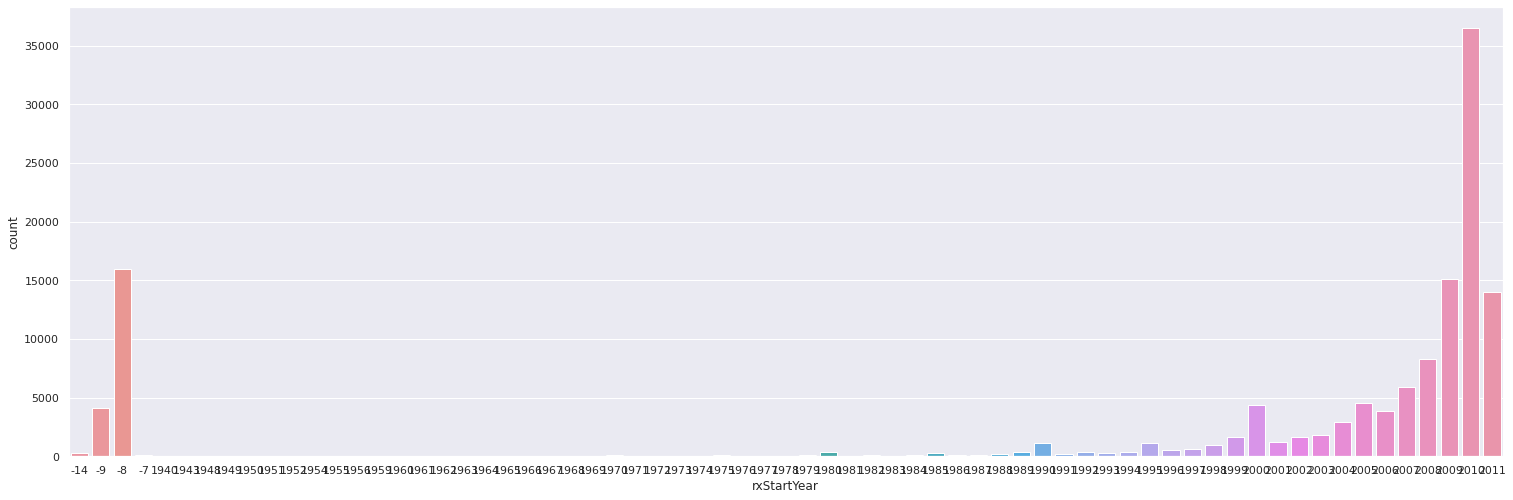

In [15]:
#Large portion of rx Year data is negative
sns.set(rc={'figure.figsize':(25.7,8.27)})
sns.countplot(df_meds['rxStartYear'])

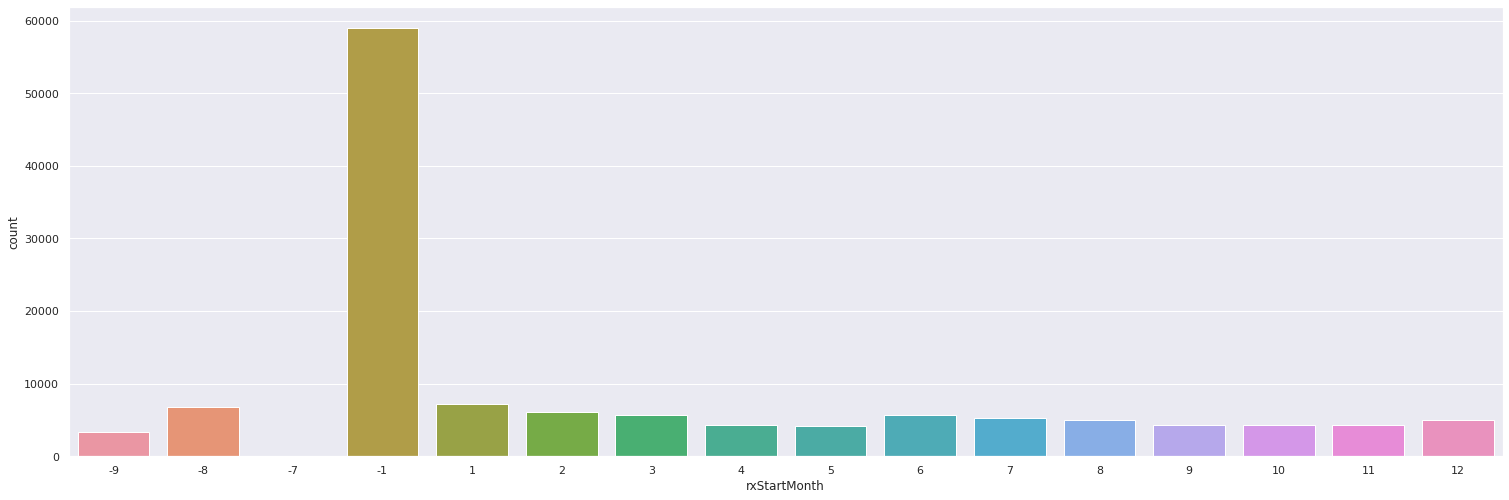

In [16]:
sns.set(rc={'figure.figsize':(25.7,8.27)})
sns.countplot(df_meds['rxStartMonth'])

Around 40% of date related years are negative, i.e. may be faulty.
Around 72% of months are negative 
We need to decide if we need to clean the dataset from them, given their large presence 

In [17]:
print (df_meds['rxStartYear'][df_meds['rxStartYear']<0].count()/df_meds['rxStartYear'].count())
print (df_meds['rxStartMonth'][df_meds['rxStartMonth']<0].count()/df_meds['rxStartMonth'].count())

0.15682724762196992
0.5296026388462719


Lets see what years we have for  negative months. Apparently, we have valid years for negative months.

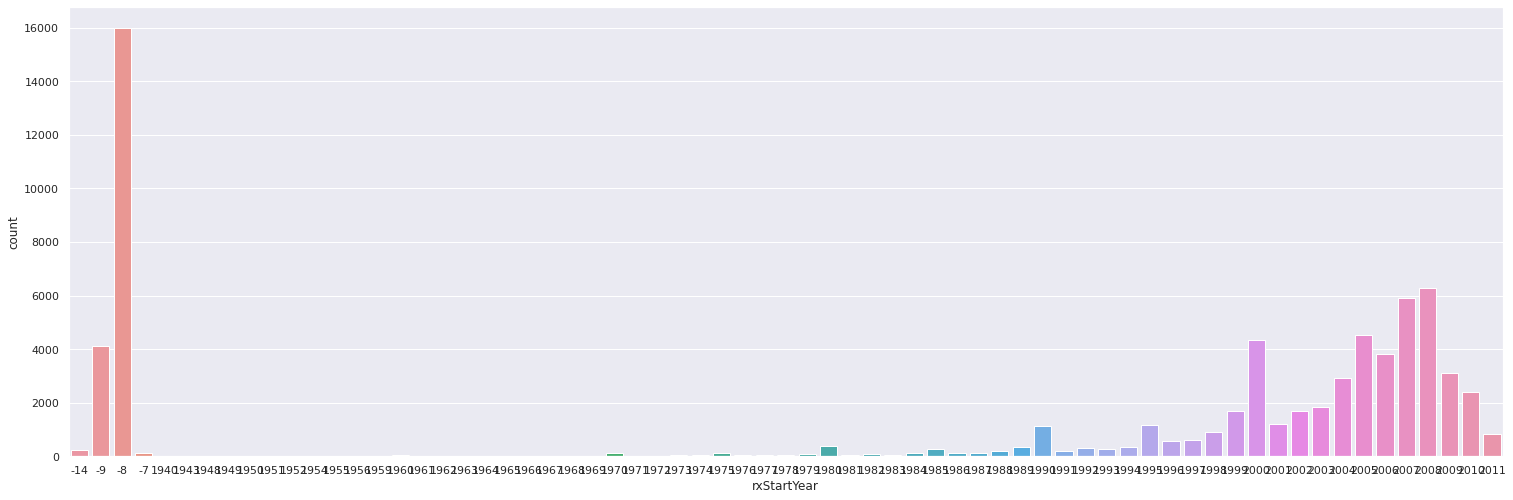

In [18]:
sns.countplot(df_meds['rxStartYear'][df_meds['rxStartMonth']<0])

In [19]:
df_meds['rxStartYear'][df_meds['rxStartMonth']<0].value_counts().sort_index()

-14        241
-9        4100
-8       15980
-7         123
 1940        3
         ...  
 2007     5894
 2008     6264
 2009     3105
 2010     2404
 2011      835
Name: rxStartYear, Length: 67, dtype: int64

For negative years we have all negative months

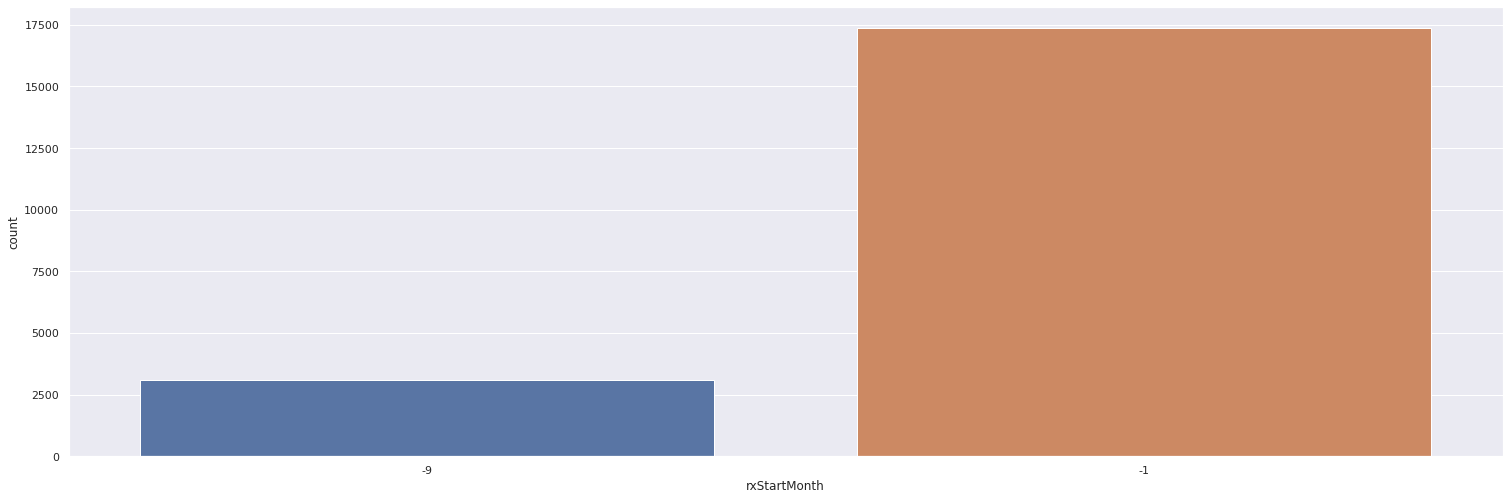

In [20]:
sns.countplot(df_meds['rxStartMonth'][df_meds['rxStartYear']<0])

We need to make a decision about negative months and years. What we will do is to analyze full datasete and dataset containing the last 10 years since the max date 2011. Per describe function , the 50% quartile for years starts with 2011 and as such we will create a dataframe where years start with 2001.

In [21]:
#check the null data
df_meds.isnull().mean()

id              0.000000
rxStartMonth    0.000000
rxStartYear     0.000000
rxName          0.000000
rxNDC           0.000000
rxQuantity      0.000008
rxForm          0.000008
dtype: float64

Given the meps_base_data & meps_meds data sets:
- *What are the most common medications for each disease in the base file?* 
To solve it, we need to group by disease
- *What medications are most indicative of each disease?*
- Demonstrate that the end user should be confident in the result.

In [22]:
#Lets create two joined tables, one with cleaned date, i.e. more than 0 and another with all dates
df_join = df_base.merge(df_meds, on = 'id', how ='inner')
#df_join_date = df_base.merge(df_meds_date, on = 'id', how ='inner')
df_join.head()

,Unnamed: 0,id,panel,pooledWeight,age,sex,race,married,highBPDiagnosed,diabetesDiagnosed,...,emphysemaDiagnosed,asthmaDiagnosed,otherHDDiagnosed,heartFailureDiagnosed,rxStartMonth,rxStartYear,rxName,rxNDC,rxQuantity,rxForm
0,1,10007101,15,3603.881236,28,Male,White,MARRIED,Yes,No,...,No,No,No,No,-1,2005,ATENOLOL,68382002210,30.0,TABS
1,1,10007101,15,3603.881236,28,Male,White,MARRIED,Yes,No,...,No,No,No,No,1,2010,AZITHROMYCIN,59762314001,30.0,SUSR
2,1,10007101,15,3603.881236,28,Male,White,MARRIED,Yes,No,...,No,No,No,No,12,2010,ATENOLOL,51079068463,90.0,TAB
3,2,10007102,15,2544.550424,25,Female,White,MARRIED,No,No,...,No,Yes,No,No,2,2009,TREXIMET,173075000,18.0,TABS
4,2,10007102,15,2544.550424,25,Female,White,MARRIED,No,No,...,No,Yes,No,No,8,2010,HYDROCO/APAP,406036005,10.0,TABS


 Lets analyze the diabetes column to see it's values distribution. It's not clear what column DK stands for. 
However its count is small so we can probably ignore it

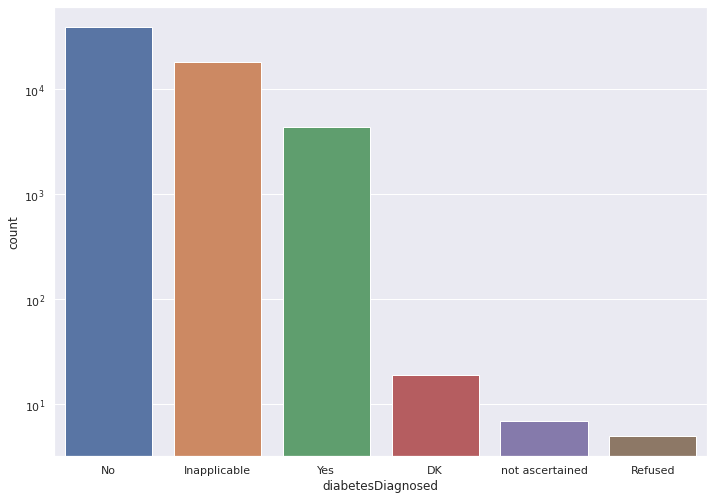

In [23]:

  sns.set(rc={'figure.figsize':(11.7,8.27)})
  g=sns.countplot(df_base['diabetesDiagnosed'])
  g.set_yscale("log")

In [24]:
#Lets check the above data in numbers 
df_join[['diabetesDiagnosed','rxName']].groupby('diabetesDiagnosed')['rxName'].count()

diabetesDiagnosed
Inapplicable    13024
No              83397
Refused             4
Yes             33935
Name: rxName, dtype: int64

Lets calculate the top 3 medicines for all diseases where the diagnosis is Yes in absolute and percentage values

In [25]:
lst=[]
for i in dis:
  temp_series = df_join[df_join[i]=='Yes'].groupby('rxName').count()[i].sort_values(ascending=False).head(3)
  lst.append(temp_series)
dis_medicine= pd.concat(lst, axis=1)
dis_medicine

,highBPDiagnosed,diabetesDiagnosed,chdDiagnosed,miDiagnosed,anginaDiagnosed,strokeDiagnosed,emphysemaDiagnosed,asthmaDiagnosed,otherHDDiagnosed,heartFailureDiagnosed
rxName,,,,,,,,,,
LISINOPRIL,3091.0,1232.0,561.0,416.0,NaN,323.0,189.0,NaN,755.0,149.0
SIMVASTATIN,2587.0,1200.0,689.0,475.0,272.0,438.0,186.0,NaN,766.0,NaN
METFORMIN,1912.0,2274.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FUROSEMIDE,NaN,NaN,530.0,352.0,237.0,278.0,NaN,NaN,600.0,229.0
PLAVIX,NaN,NaN,NaN,NaN,233.0,NaN,NaN,NaN,NaN,NaN
HYDROCO/APAP,NaN,NaN,NaN,NaN,NaN,NaN,198.0,NaN,NaN,NaN
ALBUTEROL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,656.0,NaN,NaN
SINGULAIR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,563.0,NaN,NaN
AZITHROMYCIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,505.0,NaN,NaN


In [26]:
#Lets calculate the percentage of each medicine to all diagnosed patients for each type of condition
lst=[]
for i in dis:
  temp_series = dis_medicine[i]/df_join[df_join[i]=='Yes'][i].count()
  lst.append(temp_series)

dis_medicine_perc= pd.concat(lst, axis=1)

dis_medicine_perc

,highBPDiagnosed,diabetesDiagnosed,chdDiagnosed,miDiagnosed,anginaDiagnosed,strokeDiagnosed,emphysemaDiagnosed,asthmaDiagnosed,otherHDDiagnosed,heartFailureDiagnosed
rxName,,,,,,,,,,
LISINOPRIL,0.041644,0.036305,0.031485,0.034287,NaN,0.026991,0.024197,NaN,0.030316,0.036051
SIMVASTATIN,0.034854,0.035362,0.038669,0.039149,0.028908,0.036601,0.023813,NaN,0.030758,NaN
METFORMIN,0.025760,0.067010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FUROSEMIDE,NaN,NaN,0.029745,0.029012,0.025189,0.023231,NaN,NaN,0.024093,0.055408
PLAVIX,NaN,NaN,NaN,NaN,0.024764,NaN,NaN,NaN,NaN,NaN
HYDROCO/APAP,NaN,NaN,NaN,NaN,NaN,NaN,0.025349,NaN,NaN,NaN
ALBUTEROL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027577,NaN,NaN
SINGULAIR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.023667,NaN,NaN
AZITHROMYCIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.021229,NaN,NaN


Lets create a function for the above, and include years to be filtered on and top medicines by count

In [27]:
def medicine_pop(df,year,top_n):
  lst=[]
  for i in dis:
    temp_series = df[(df[i]=='Yes')& (df['rxStartYear']>=year)].groupby('rxName').count()[i].sort_values(ascending=False).head(top_n)
    lst.append(temp_series)
  dis_medicine= pd.concat(lst, axis=1)
#dis_medicine
  for i in dis:
    temp_series = dis_medicine[i]/df_join[(df_join[i]=='Yes')&(df['rxStartYear']>=year)][i].count()
    lst.append(temp_series)

  dis_medicine_perc= pd.concat(lst, axis=1)

  return dis_medicine, dis_medicine_perc

# Below is the answer to the first question, what the most common medicine for each disease? I counted the top three medicines for each disease by absolute and percentage values, where some medicines may have been assigned more than one time and it's still counted towards the common occurence.

In [28]:
medicine_pop(df_join,df_join['rxStartYear'].min(), 3)

(              highBPDiagnosed  diabetesDiagnosed  chdDiagnosed  miDiagnosed  \
 rxName                                                                        
 LISINOPRIL             3091.0             1232.0         561.0        416.0   
 SIMVASTATIN            2587.0             1200.0         689.0        475.0   
 METFORMIN              1912.0             2274.0           NaN          NaN   
 FUROSEMIDE                NaN                NaN         530.0        352.0   
 PLAVIX                    NaN                NaN           NaN          NaN   
 HYDROCO/APAP              NaN                NaN           NaN          NaN   
 ALBUTEROL                 NaN                NaN           NaN          NaN   
 SINGULAIR                 NaN                NaN           NaN          NaN   
 AZITHROMYCIN              NaN                NaN           NaN          NaN   
 CARVEDILOL                NaN                NaN           NaN          NaN   
 
               anginaDiagnosed  stroke

Let's test the results by reconciling percentage results from same df using different methods

In [29]:

medicine_pop(df_join,df_join['rxStartYear'].min(), 3)[1].loc['METFORMIN','diabetesDiagnosed' ].iloc[1]==\
df_join[(df_join['diabetesDiagnosed']=='Yes')&(df_join['rxName']=='METFORMIN')].count()['id']/\
df_join[df_join['diabetesDiagnosed']=='Yes'].count()['id']

True

As we can see from above, in case of diabetes, Metformin is prescribed to 3.6% of all patients who were diagnosed with Diabetes. Below we can see that 4186 types of medicines are prescribed to diabetes patients

In [30]:
df_join[df_join['diabetesDiagnosed']=='Yes'].groupby('rxName').size().sort_values(ascending=False)

rxName
METFORMIN                 2274
LISINOPRIL                1232
SIMVASTATIN               1200
FUROSEMIDE                 601
INSULIN SYRG               577
                          ... 
ESOMEPRAZOLE MAGNESIUM       1
PAXIL CR                     1
PED ELCTRLYT FRUIT           1
ERYTHROMYCIN OP              1
ZZFEXOFENADINE               1
Length: 1977, dtype: int64

Lets calculate values for 2001 year, thus taking the last 10 years since 2011, as older data is scarce with the majority of dates being negative. In this case, Metforming was prescribed to 4.5% of all diagnosed by diabetes. 

In [31]:
medicine_pop(df_join,2001, 3)

(              highBPDiagnosed  diabetesDiagnosed  chdDiagnosed  miDiagnosed  \
 rxName                                                                        
 LISINOPRIL             2126.0              838.0         356.0        287.0   
 SIMVASTATIN            1700.0              738.0         433.0        299.0   
 METFORMIN              1303.0             1524.0           NaN          NaN   
 PLAVIX                    NaN                NaN         314.0        222.0   
 HYDROCO/APAP              NaN                NaN           NaN          NaN   
 SINGULAIR                 NaN                NaN           NaN          NaN   
 AZITHROMYCIN              NaN                NaN           NaN          NaN   
 FUROSEMIDE                NaN                NaN           NaN          NaN   
 CARVEDILOL                NaN                NaN           NaN          NaN   
 
               anginaDiagnosed  strokeDiagnosed  emphysemaDiagnosed  \
 rxName                                        

As we can see there is a extremely right-tale distribution of medicines given during diabetes

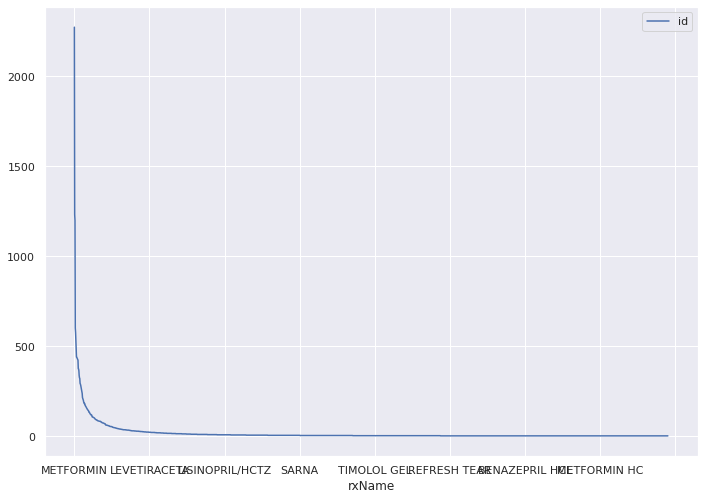

In [32]:
df_join[df_join['diabetesDiagnosed']=='Yes'].groupby('rxName').count()['id'].sort_values(ascending=False).reset_index().plot(x='rxName',y='id')#.set_xscale('log')

Lets select diabetes as it looks to have a good size of diagnozed patients

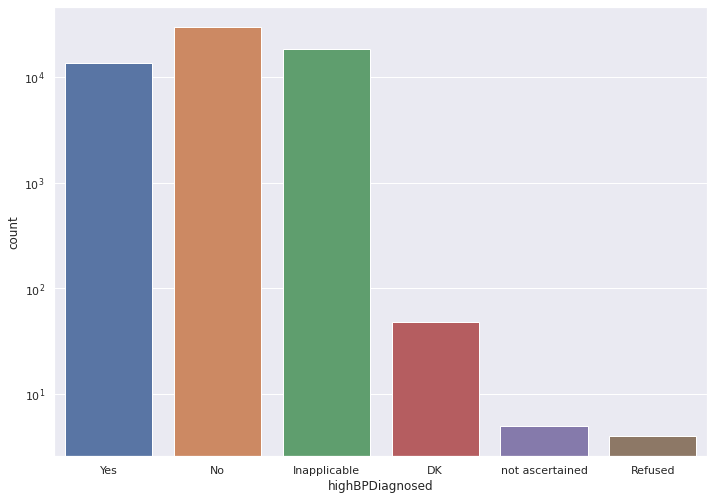

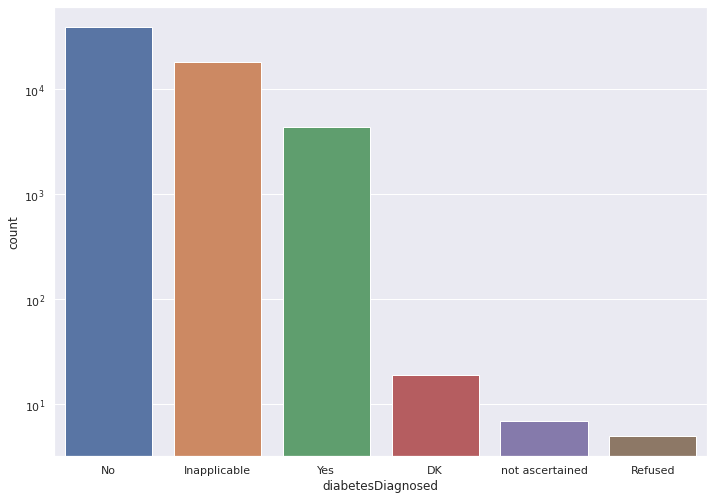

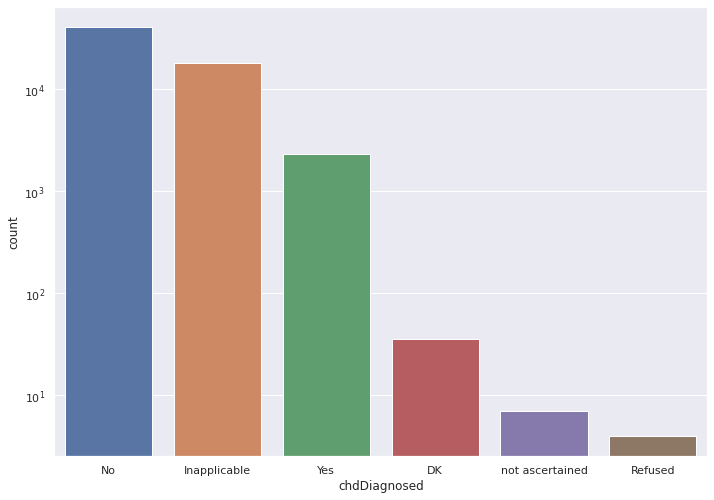

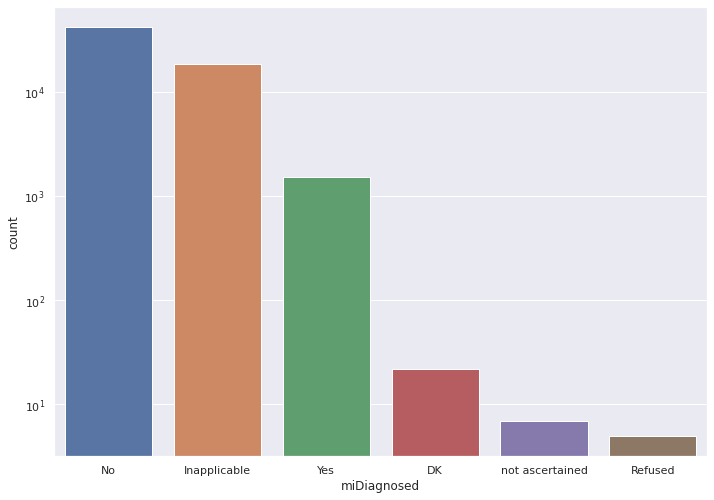

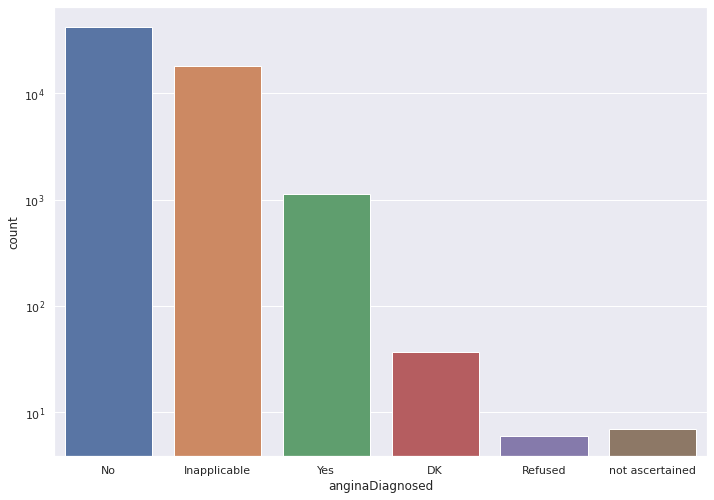

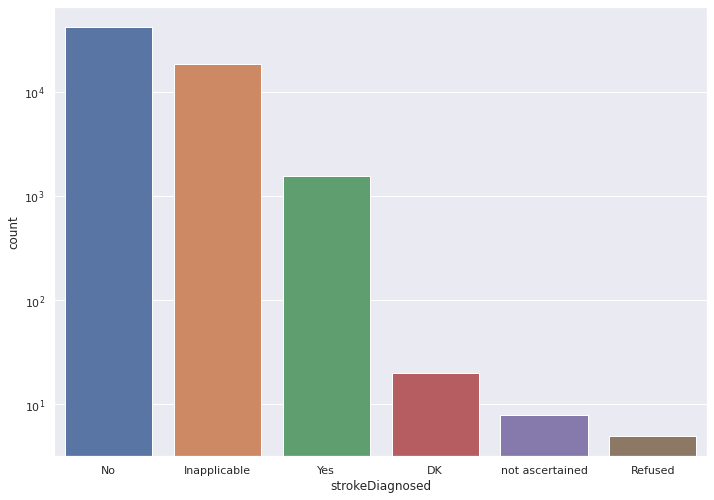

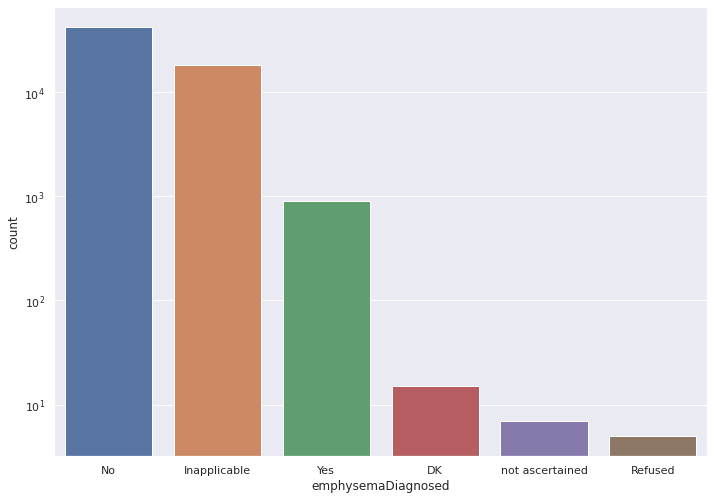

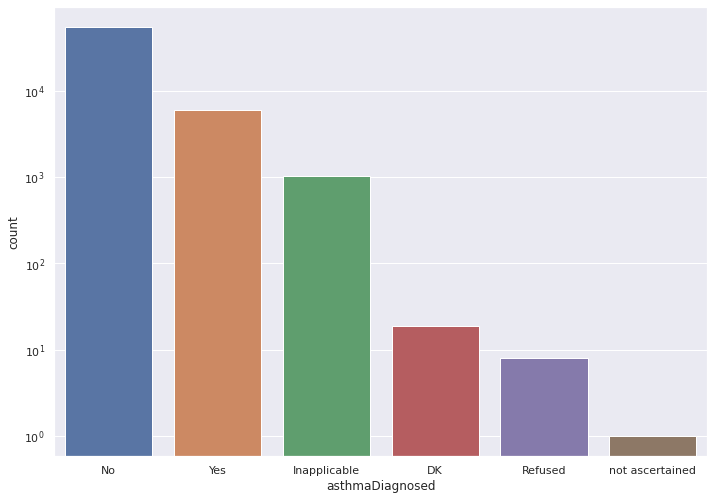

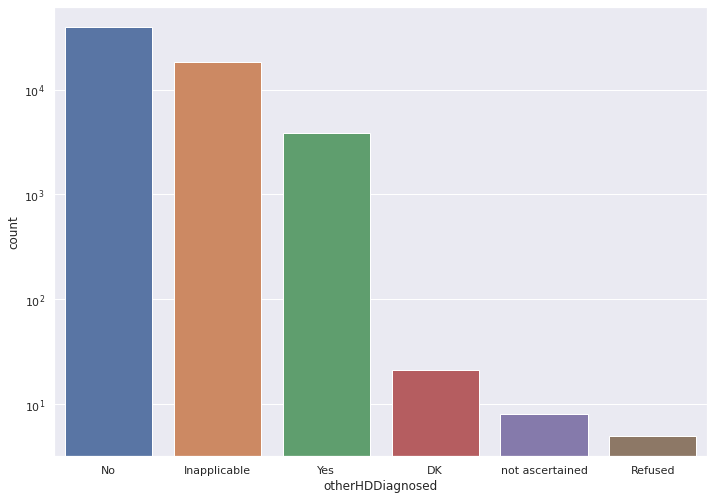

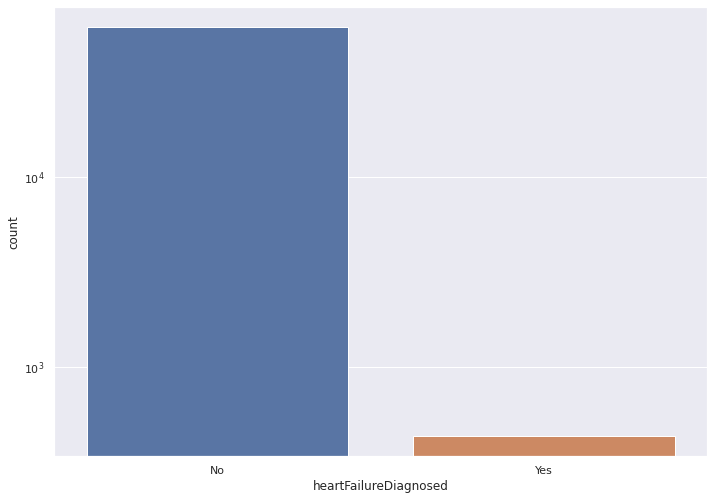

In [33]:
for i in dis:
  #print (df_base.groupby(i).count()['id'])
  g=sns.countplot(df_base[i])
  g.set_yscale("log")
  plt.show()


#What medications are most indicative of each disease?
Let's select top 10 medicines and group them in respect for each disease. For example, 87% of all total Metformin prescriptions and 37% of total Lisinopril prescriptions up to latest date have users with diabetes. In other words some medicinces were prescribed more than 1 time and they were double counted in the below table, i.e. we didn't normalize the table for each medicine to be considered only once. 

In [34]:
'''
t = df_join.set_index('rxName')[dis].stack()
t= t[t=='Yes'].reset_index()
lst=[]
for rx_name in most_common_rx_names:
  lst.append(t[t['rxName']==rx_name]['level_1'].value_counts(normalize=True).rename(rx_name))
dis_prev= pd.concat(lst, axis=1)
dis_prev
'''
most_common_rx_names = df_join['rxName'].value_counts().head(10).index
(df_join.set_index('rxName')[dis]=='Yes').groupby(level=0).mean().loc[most_common_rx_names]

,highBPDiagnosed,diabetesDiagnosed,chdDiagnosed,miDiagnosed,anginaDiagnosed,strokeDiagnosed,emphysemaDiagnosed,asthmaDiagnosed,otherHDDiagnosed,heartFailureDiagnosed
SIMVASTATIN,0.717614,0.332871,0.191123,0.131761,0.075451,0.121498,0.051595,0.112621,0.212483,0.024965
LISINOPRIL,0.885420,0.352907,0.160699,0.119164,0.064738,0.092524,0.054139,0.132340,0.216270,0.042681
AZITHROMYCIN,0.261433,0.080887,0.046075,0.028669,0.027986,0.027645,0.034130,0.172355,0.091809,0.009556
AMOXICILLIN,0.147595,0.046647,0.028426,0.016399,0.014942,0.014213,0.011662,0.134111,0.063047,0.003644
HYDROCO/APAP,0.483980,0.163588,0.080286,0.057294,0.060686,0.081794,0.074632,0.182435,0.173766,0.016962
METFORMIN,0.721509,0.858113,0.129057,0.092075,0.069057,0.083396,0.051698,0.147925,0.173208,0.019245
AMLODIPINE,0.943416,0.268641,0.176626,0.110524,0.076150,0.135907,0.054469,0.114754,0.215230,0.033845
IBUPROFEN,0.288978,0.105083,0.028555,0.026271,0.024557,0.034266,0.023415,0.154769,0.085094,0.005711
OMEPRAZOLE,0.668409,0.254936,0.166086,0.115563,0.116144,0.112079,0.090592,0.201510,0.227062,0.038328
LEVOTHYROXIN,0.524118,0.188235,0.104706,0.070000,0.045882,0.074706,0.033529,0.145294,0.187059,0.027059


#Choose ONE of the diseases and build a model to infer whether that disease is present from the medications.
We will create a model with dependend variable being Yes or Not Yes diagnosis (by grouping all other values into Not Yes) for Diabites and independent variables being medicines. It makes sense to include all Not Yeas values (including Inapplicable, DK etc.), as the presence of some medicines may indicated that it's not a diabetes but another disease).
We will make sure that each medicine is present only once for each patient in the below table for the model to work in accordance with our assumptions. 

In [ ]:
#Lets select 10% of data as otherwise, the System RAM is crashing.
disease ='diabetesDiagnosed'
df_model = df_join[['id','rxName',disease]].sample(frac=0.1).copy()
print (df_model.shape)
df_model[disease] = df_model[disease]=='Yes'
df_model.drop_duplicates(inplace=True)
print (df_model.shape)
# Lets create dummy variables and make sure that each id and desease has one value for each disease
df_model = pd.get_dummies(df_model, prefix='', prefix_sep='', columns=['rxName'])
df_model = df_model.groupby(['id',disease]).sum().reset_index(level=1)



(34276, 3)
(32564, 3)


Below we applied logistic regression, one of the simplest but interpretable models and there is a difference in roc auc scores for test and train datasets, as there lots of features and the model behaves a bit differently for each dataset. It should be noted that it's not clear what is the best score here, as the task in hand - determine whether the person has a diabetes based on the medications given is quite challenging. As we saw from the previous analysis, very often one medicine is given to all conditions. Also, diabetes is present in combination with many other diseases like highblood pressure and etc.

In [ ]:
from sklearn.metrics import  plot_precision_recall_curve
X,y=df_model.drop(columns=disease), df_model[disease]
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.3, random_state=42)
ln= LogisticRegression()
ln.fit(X_train, y_train)
y_pred_test = ln.predict_proba(X_test)[:,1]
y_pred_train = ln.predict_proba(X_train)[:,1]
roc_train, roc_test =  roc_auc_score(y_train, y_pred_train), roc_auc_score(y_test, y_pred_test) 
print ('roc_train: ', roc_train, 'roc_test :', roc_test)



roc_train:  0.9164522506628647 roc_test : 0.8272699011181006


Here is the plot of precision vs recall and even though it looks like the model is better than naive estimation of the disease but by not much margin. For example, at recall level of 0.8 (i.e. we predict correctly 80% of predictions), we only identify around 50% of all people with diabetes. It means that if we are interested in identifying as many people with diabetes as possible, then we need to apply some other model.

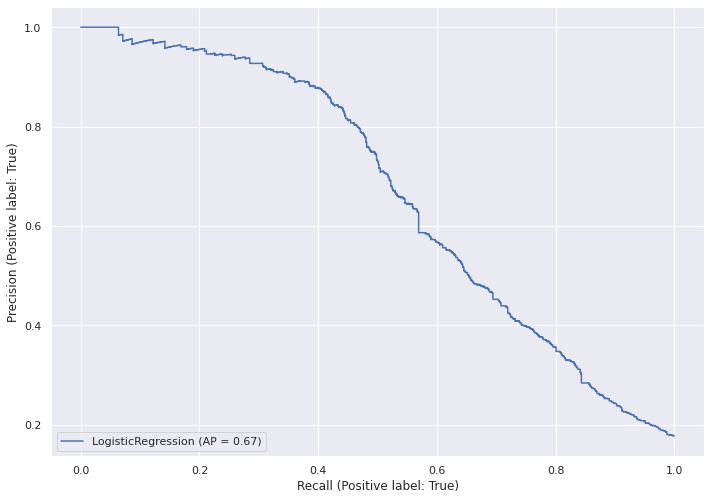

In [ ]:
plot_precision_recall_curve(ln, X_test, y_test)

In [ ]:
%pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.2 MB/s 


Lets try another model which is much more powerful - catboost. If we increase the parameters, the roc auc score increases, but not significantly. 

In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(n_estimators=300, learning_rate=0.1, max_depth=10)
model.fit(X_train, y_train, silent=True)
y_pred_test = model.predict_proba(X_test)[:,1]
y_pred_train = ln.predict_proba(X_train)[:,1]
roc_train, roc_test =  roc_auc_score(y_train, y_pred_train), roc_auc_score(y_test, y_pred_test) 
print ('roc_train: ', roc_train, 'roc_test :', roc_test)

roc_train:  0.9164522506628647 roc_test : 0.8264577231921997
